## Problem Description

### The Goal:
You work as a data scientist at a credit card company. A senior VP is leading an effort to reduce costs associated with signup incentives by offering credit cards with carefully targeted benefits that will attract new cardholders. As a first step, she would like you to examine cardholder data collected over the last 6 months in order to understand the various kinds of users who use the company’s products. She is especially interested in getting an idea of which benefits to associate with each new card offering.
### The Data:
The data consists of a csv file with 8950 rows (one for each cardholder) organized in columns with descriptive headers.

In [1]:
# Import packages for data analysis

# Check the versions of key python libraries
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
print('sklearn: %s' % sklearn.__version__)
import datetime

scipy: 1.3.1
numpy: 1.17.2
matplotlib: 3.0.3
pandas: 0.25.1
statsmodels: 0.10.1
sklearn: 0.21.3


In [2]:
# Import packages for data visualization and exploration

###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

# Import libraries for data visualization
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()

# Pretty display for notebooks
%matplotlib inline

# Optional global parameter tuning for data visualization 

#from pylab import rcParams
#matplotlib.rcParams['axes.labelsize'] = 14
#matplotlib.rcParams['xtick.labelsize'] = 12
#matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'
#rcParams['figure.figsize'] = 18, 8

# Package for fast EDA
import pandas_profiling

## Feature Set Exploration and Data Cleaning

In [4]:
# Load and display the first five rows of the data set
credit_card_raw = pd.read_csv('cc_info.csv', header=0, index_col=None)
credit_card_raw.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [5]:
# Basic data exploration
pandas_profiling.ProfileReport(credit_card_raw)

### Summary of the feature set:

**BALANCE:** Numeric. Float. Total amount owed to the company. No missing values. Minimum value: 0, maximum value: 19043.13856. Mean: 1564.474828. Right-skewed. 0.9\% of the values are zero.

**BALANCE_FREQ:** Numeric. Float. Conjecture: The percentage of time there is a positive balance in the account. No missing values. Min: 0, Max: 1, Mean: 0.85. Left-skewed. 69.4\% has value 1 and 0.9\% has value 0.

**CASH_ADVANCE:** Numeric. Float. Conjecture: Cash advance withdrawn from the credit card account. Min: 0, Max: 47137.21176, Mean: 978.8711125. Right-skewed 51.7\% has value 0. 

**CASH_ADVANCE_FREQUENCY:** Numeric. Float. Frequency that a positive cash advance is withdrawn from the credit card account. No missing values. Min: 0, Max: 1.5, Mean: 0.1351. Right-skewed. 51.7\% has value 0, 11.4\% has value 0.083333. Check the numbers larger than 1 and try to come up with a formula.

**CASH_ADVANCE_TRX:** Numeric. Integer. The number of total cash advance transactions. No missing values. Min:0, max:123, mean:3.25. Right-skewed. 51.7\% has value 0. 

**CREDIT_LIMIT:** Numeric. Float. Monthly total cash advance plus purchase limit. 1 missing value. Min: 50, max: 30000, mean: 4494.4. Right-skewed. 8.8\% has value 3000.

**CUST_ID:** Categorical. Unique. Customer ID. No missing values. 

**INSTALLMENTS_PURCHASES:** Numeric. Float. Purchases charged to the credit card in installments such as subscriptions. No missing values. Min: 0, max: 22500, mean:411.1. Right-skewed. 43.8\% has value 0.

**MINIMUM_PAYMENTS:** Numeric. Float. Minimum payment required to be paid. Conjecture: A certain percentage of balance plus a finance fee. 313 missing values (3.5\%). Min:0.019 , max: 76406, mean:864.2.  Right-skewed. 

**ONEOFF_PURCHASES:** Numeric. Float. Total one-time purchase amount. No missing values. Min: 0, max: 40761, mean:592.43. Right-skewed. 48.1\% has zero value.

**ONEOFF_PURCHASES_FREQUENCY:** Numeric. Float. Frequency of one-off purchases. Min:0, max:1, mean:0.2. Right-skewed. 48.1\% has zero value, 5.4\% has value 1.

**PAYMENTS:** Numeric. Float. Payment made by the customer. No missing values. Min:0, max: 50721, mean: 1733. Right-skewed. 2.7\% has zero value.

**PRC_FULL_PAYMENT:** Numeric. Float. Conjecture: The frequency the customer made a full payment. No missing values. Min: 0, max:1, mean: 0.15. Right-skewed. 66\% has value zero.

**PURCHASES:** is the sum of ONEOFF_PURCHASES and INSTALLMENTS_PURCHASES and will be ignored in the analysis.

**PURCHASES_FREQUENCY:** Numeric. Float. The frequency a customer made a purchase. No missing values. Min: 0, max:1, mean: 0.49. Bimodal. 22.8\% has zero values, 24.3\% has values 1.

**PURCHASES_INSTALLMENTS_FREQUENCY:** Numeric. Float. The frequency the customer made an installment purchase. No missing values. Min:0, max=1, mean: 0.36. Bimodal. 43.7\% has zero values, 14.9\% has value 1.

**PURCHASES_TRX:** Numeric. Integer. The number of total purchase transactions.  No missing values. Min:0, max=358, mean: 14.7. 22.8\% has zero values. Right-skewed.

**TENURE:** Numeric. Integer. Conjecture: The number of months a credit card is valid. Min:6, max:12, mean: 11.5. Left-skewed. 84.7\% has value 12. 

In [6]:
credit_card_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

In [9]:
# Drop PURCHASES as it is the sum of two other features
credit_card_raw.drop('PURCHASES', axis=1, inplace=True)

KeyError: "['PURCHASES'] not found in axis"

In [10]:
credit_card_raw.shape

(8950, 17)

In [16]:
credit_card_raw.set_index('CUST_ID',inplace=True)

KeyError: "None of ['CUST_ID'] are in the columns"

In [17]:
credit_card_raw.shape

(8950, 16)

## Missing Values

There are two columns with missing values: CREDIT_LIMIT has one missing value, MINIMUM_PAYMENTS has 313 missing values.

In [18]:
# Find the number of null values in CREDIT_LIMIT
credit_card_raw['CREDIT_LIMIT'].isnull().sum()

1

In [19]:
# Drop the row with numm value
credit_card_cl_null_droppped=credit_card_raw[credit_card_raw['CREDIT_LIMIT'].notnull()]
credit_card_cl_null_droppped.shape

(8949, 16)

In [20]:
# Number of null values in MINIMUM PAYMENTS
credit_card_cl_null_droppped['MINIMUM_PAYMENTS'].isnull().sum()

313

In [30]:
# When the PAYMENT is zero, all MINIMUM_PAYMENTS are null.
credit_card_cl_null_droppped['MINIMUM_PAYMENTS'][credit_card_cl_null_droppped['PAYMENTS']==0].isnull().sum()

240

I will delay dealing with MINIMUM_PAYMENTS until after I draw the scatterplots below.

## Exploratory Data Analysis and Visualizations

### Analysis on Numeric Features

In [33]:
def analyze_features(dataset):
    """
    Identify and draw histograms for numeric features
    """
    # Define the color and font size for the plot below
    base_color = sns.color_palette()[0]
    # Identify numeric features in the data set
    numeric_columns=dataset.columns
    numeric_column_number=len(numeric_columns) # Number of numeric features
    axis_length=8 # Base axis length for each graph
    total_y_axis_length=axis_length*numeric_column_number
    f, ax = plt.subplots(numeric_column_number,1,figsize=(axis_length,total_y_axis_length))
    for i, label in enumerate(numeric_columns):
        extra=(dataset[label].max()-dataset[label].min())/14 
        bin_edges=np.arange(dataset[label].min(), np.ceil(dataset[label].max())+extra, extra)
        sns.distplot(dataset[label], bins=bin_edges, vertical=True, kde=False, hist_kws={'alpha':1}, ax= ax[i]) 
        ax[i].set_xlabel('Count')
    f.tight_layout()
    f.show()   
    return                

def numeric_scatterplots(dataset):
    """
    Draw scatter plots of all combinations of numeric features
    """
    from itertools import combinations
    base_color = sns.color_palette()[0]
    numeric_columns=dataset.select_dtypes(include=['int','float']).columns.values.tolist()
    numeric_column_number=len(numeric_columns) # Number of numeric features
    axis_length=5 # Base axis length for each graph
    total_y_axis_length=axis_length*len(list(combinations(numeric_columns,2)))
    f, ax = plt.subplots(len(list(combinations(numeric_columns,2))),1,figsize=(1.5*axis_length,total_y_axis_length))
    for i, (x,y) in enumerate(list(combinations(numeric_columns,2))):
        sns.regplot(dataset[x],dataset[y], color=base_color, scatter_kws={'alpha':0.1}, ax=ax[i])   

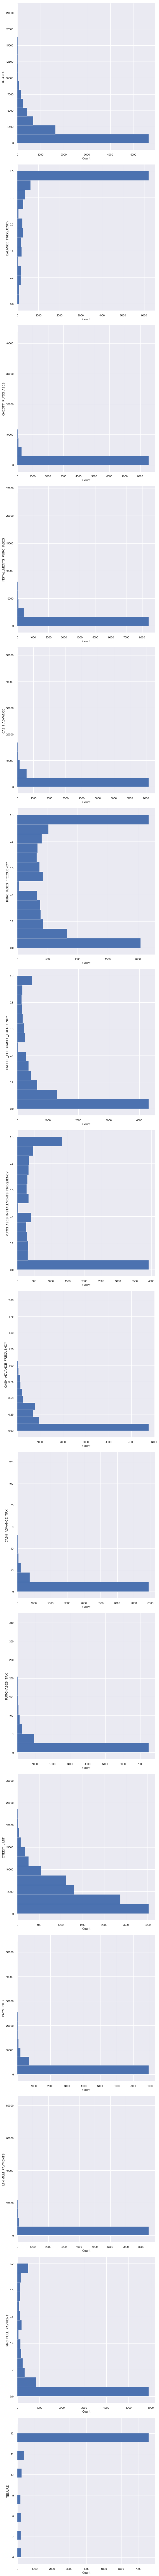

In [34]:
analyze_features(credit_card_cl_null_droppped)

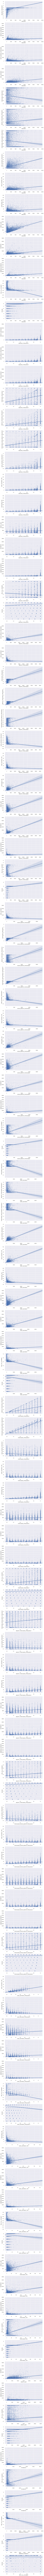

In [35]:
numeric_scatterplots(credit_card_cl_null_droppped)

The above scatterplot between BALANCE and MINIMUM_PAYMENTS shows a linear relationship between them. I will fit a linear line and get the intercept and slope of the line to use for null values of MINIMUM_PAYMENTS.

In [43]:
fitting_log=np.polynomial.polynomial.Polynomial.fit(credit_card_cl_null_droppped['MINIMUM_PAYMENTS'][credit_card_cl_null_droppped['MINIMUM_PAYMENTS'].notnull()], credit_card_cl_null_droppped['BALANCE'][credit_card_cl_null_droppped['MINIMUM_PAYMENTS'].notnull()],
                                         deg=1)
# See the intercept and slope if the linear fit
intercept, slope=fitting_log.convert().coef
print('intercept:',intercept,'slope:',slope)

intercept: 1296.8817988719238 slope: 0.3521246712288322


In [46]:
# Replace the null values of minimum payments by slope*BALANCE+intercept
credit_card_cl_null_droppped['MINIMUM_PAYMENTS'][credit_card_cl_null_droppped['MINIMUM_PAYMENTS'].isnull()]=slope*credit_card_cl_null_droppped['BALANCE'][credit_card_cl_null_droppped['MINIMUM_PAYMENTS'].isnull()]+intercept    

# Show the numner of missing MINIMUM_PAYMENTS left
credit_card_cl_null_droppped['MINIMUM_PAYMENTS'].isnull().sum()

0

In [48]:
# Rename the cleaned data set
credit_card_cleaned=credit_card_cl_null_droppped
credit_card_cleaned.shape

(8949, 16)

In [79]:
# Visualize skewed continuous features of original and transformed data
from math import ceil
def distribution(data, features,transformed=False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Define the color for the plot
    base_color = sns.color_palette()[0]
    
    # Create figure
    fig = plt.figure(figsize=(11,35))

    # Skewed feature plotting
    for i, feature in enumerate(features):
        ax = fig.add_subplot(8,2,i+1)
        ax.hist(data[feature], bins = 25, color = base_color)
        ax.set_title("%s Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Features", \
            fontsize = 12, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Features", \
            fontsize = 12, y = 1.03)

    fig.tight_layout()
    fig.show()

All features are left or right-skewed in the data set as indicated in the feature set descriptions and plots so I will first log-transform those features:

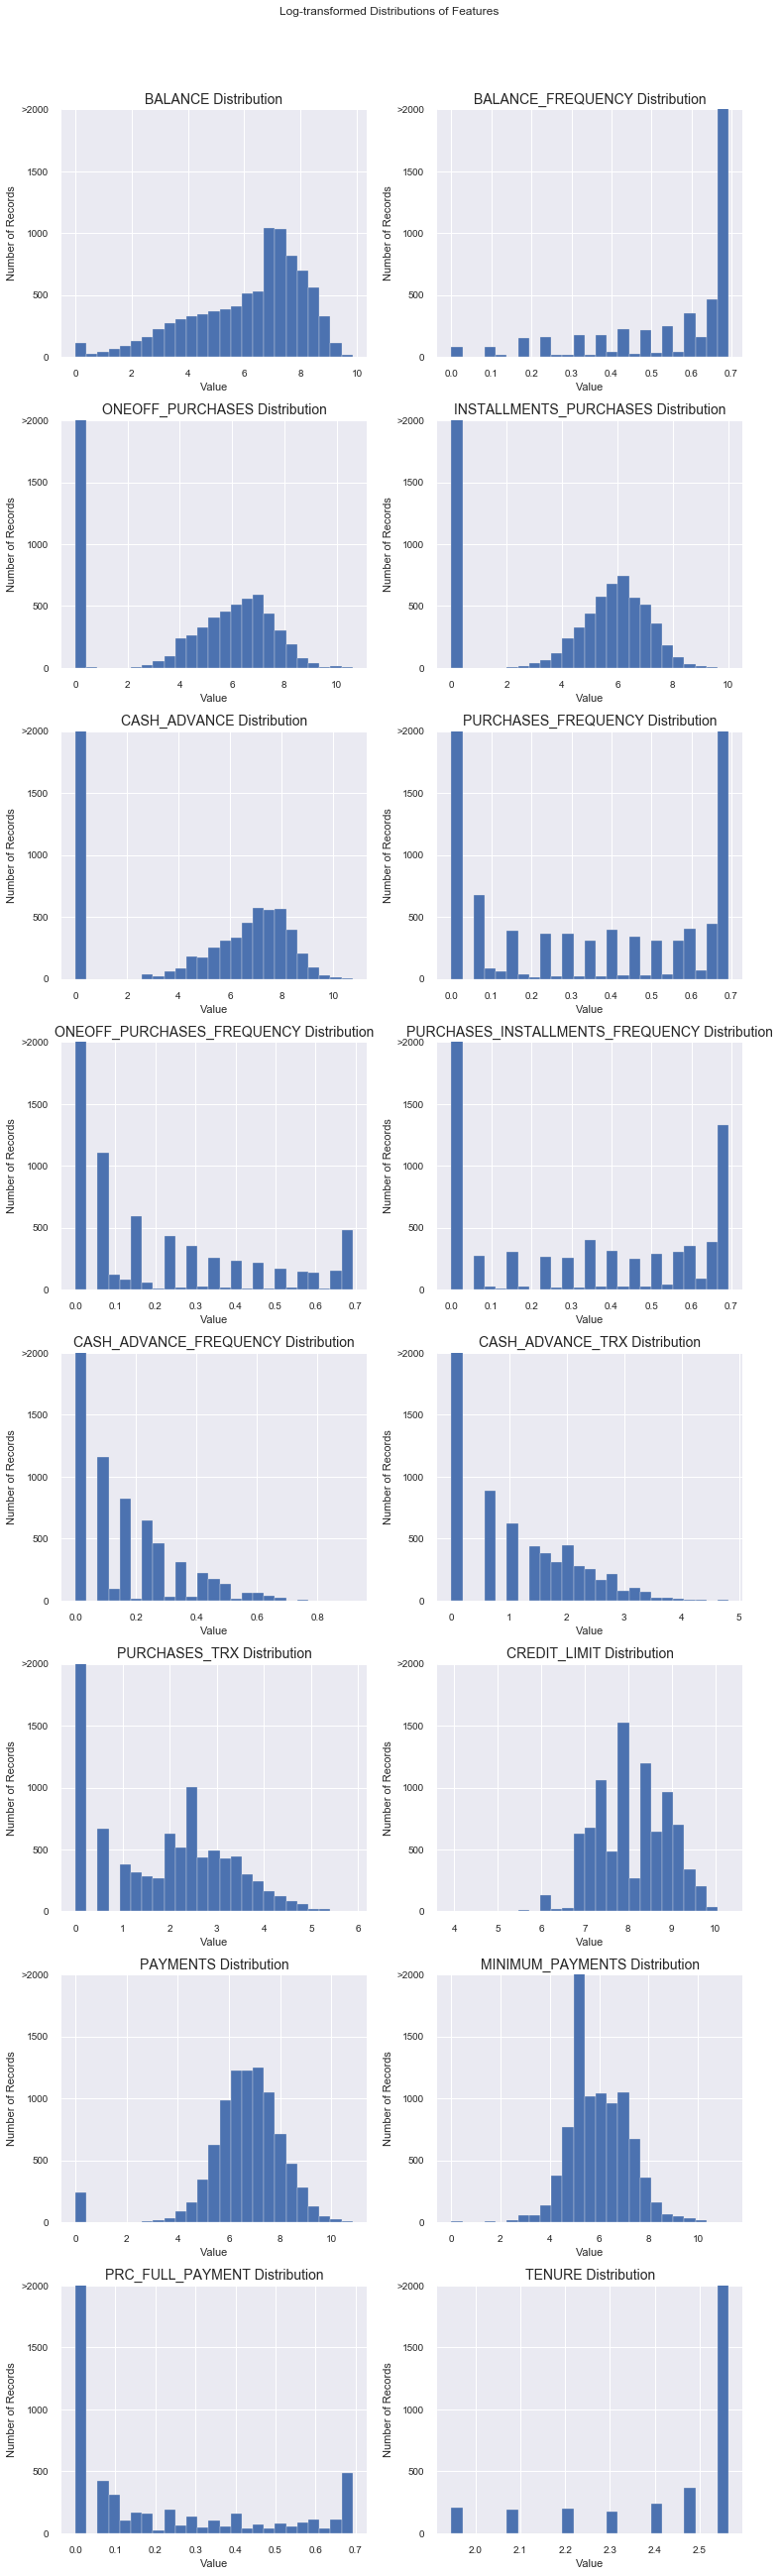

In [80]:
# Log-transform the skewed features
features_log_transformed = credit_card_cleaned.apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
distribution(features_log_transformed, features_log_transformed.columns,transformed = True)

In [83]:
# Normalize numerical features so that they are features in the interval [0,1] 
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform = scaler.fit_transform(features_log_transformed)

features_log_minmax_transform

array([[0.37904492, 0.86249662, 0.        , ..., 0.43887403, 0.        ,
        1.        ],
       [0.81911584, 0.93288587, 0.        , ..., 0.62001262, 0.28950635,
        1.        ],
       [0.79379905, 1.        , 0.62661054, ..., 0.57230266, 0.        ,
        1.        ],
       ...,
       [0.32416906, 0.87446886, 0.        , ..., 0.39242276, 0.32192809,
        0.        ],
       [0.27106538, 0.87446886, 0.        , ..., 0.35811373, 0.32192809,
        0.        ],
       [0.60109251, 0.73696588, 0.65920746, ..., 0.39848157, 0.        ,
        0.        ]])

## Model:

In [84]:
# Apply PCA to the data
from sklearn.decomposition import PCA
def do_pca(comp,df):
    pca = PCA(comp)
    X_pca = pca.fit_transform(df)
    return pca, X_pca
pca, X_pca=do_pca(features_log_minmax_transform.shape[1],features_log_minmax_transform)

In [85]:
# Investigate the variance accounted for by each principal component.
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [87]:
pca_results(features_log_transformed,pca)

Explained Variance  BALANCE  BALANCE_FREQUENCY  \
Dimension 1               0.4552  -0.0562             0.0417   
Dimension 2               0.1662   0.3381             0.2357   
Dimension 3               0.1369   0.1892             0.1665   
Dimension 4               0.0708  -0.1184            -0.0337   
Dimension 5               0.0461  -0.2869            -0.4926   
Dimension 6               0.0361   0.2481             0.5962   
Dimension 7               0.0212  -0.2697             0.1399   
Dimension 8               0.0144   0.2058            -0.2741   
Dimension 9               0.0111   0.1320             0.0762   
Dimension 10              0.0106  -0.1057             0.0998   
Dimension 11              0.0097  -0.1292             0.0841   
Dimension 12              0.0081  -0.3662             0.3402   
Dimension 13              0.0068   0.1449            -0.1411   
Dimension 14              0.0028   0.0537             0.0109   
Dimension 15              0.0026  -0.6078             0.2500   
Dimension 16              0.0015   0.0326            -0.0028   

              ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
Dimension 1             0.1805                  0.3736       -0.2792   
Dimension 2             0.4720                 -0.0712        0.3658   
Dimension 3            -0.3939                  0.2679        0.4400   
Dimension 4            -0.0429                 -0.0278        0.3034   
Dimension 5             0.1227                  0.0133        0.1954   
Dimension 6            -0.1358                 -0.1653       -0.1982   
Dimension 7            -0.4139                 -0.4021        0.1074   
Dimension 8            -0.5547                  0.0498       -0.0344   
Dimension 9            -0.0228                  0.3275        0.0351   
Dimension 10           -0.2097                  0.5540        0.0355   
Dimension 11           -0.0591                  0.1291       -0.5606   
Dimension 12            0.0479                 -0.0137        0.1486   
Dimension 13           -0.0229                 -0.3440       -0.2175   
Dimension 14           -0.1550                 -0.2043        0.0073   
Dimension 15            0.0093                 -0.0085        0.0463   
Dimension 16           -0.0147                 -0.0055       -0.1552   

              PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
Dimension 1                0.5352                      0.2134   
Dimension 2                0.1054                      0.4821   
Dimension 3                0.1099                     -0.3769   
Dimension 4                0.0114                      0.0949   
Dimension 5                0.1342                      0.1048   
Dimension 6                0.1008                      0.0063   
Dimension 7                0.4393                      0.3079   
Dimension 8                0.0780                      0.3824   
Dimension 9               -0.2036                      0.1565   
Dimension 10              -0.3160                      0.4053   
Dimension 11               0.0303                     -0.0274   
Dimension 12              -0.1996                      0.1274   
Dimension 13              -0.3784                      0.3333   
Dimension 14              -0.3414                     -0.0349   
Dimension 15              -0.1455                      0.0281   
Dimension 16              -0.0016                      0.0106   

              PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
Dimension 1                             0.4999                 -0.1177   
Dimension 2                            -0.1175                  0.1888   
Dimension 3                             0.4415                  0.2147   
Dimension 4                            -0.0524                  0.1659   
Dimension 5                             0.0576                  0.1202   
Dimension 6                            -0.0570                 -0.0587   
Dimension 7                            -0.0688                  0.0581   
Di

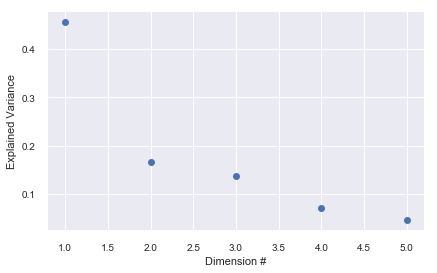

In [106]:
# Plot the explained variance
comp_check = pca_results(features_log_transformed, pca)
plt.plot(range(1,comp_check.shape[0]+1),comp_check['Explained Variance'],'bo');
plt.xlabel('Dimension #')
plt.ylabel('Explained Variance');

It looks like the first few dimensions explain the variance much more than the other dimensions.

In [96]:
# Find the number of dimensions to keep to explain at least 85% of the variability in the data set
num_comps = comp_check.shape[0]
for comp in range(num_comps):
    if comp_check['Explained Variance'][:comp].sum() >= 0.85:
        break
print("Using {} components, we can explain {}% of the variability in the original data.".format(comp,100*comp_check['Explained Variance'][:comp].sum()))

Using 5 components, we can explain 87.52% of the variability in the original data.


In [98]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca, X_pca=do_pca(comp,features_log_minmax_transform)
comp_check = pca_results(features_log_transformed,pca)
print('We can explain {}% of the variability in the original data.'.format(100*comp_check['Explained Variance'].sum()))

We can explain 87.52% of the variability in the original data.


In [102]:
# Define a function which sorts the weights of all features for the ith principal component
def pca_sort_weights(i):
    # Choose the ith PCA component
    components = pd.DataFrame(np.round(pca.components_, 4), columns =features_log_transformed.keys())
    return components.iloc[i-1].sort_values(ascending=False)

## First Group of Costumers:

In [103]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_sort_weights(1)

PURCHASES_FREQUENCY                 0.5352
PURCHASES_INSTALLMENTS_FREQUENCY    0.4999
INSTALLMENTS_PURCHASES              0.3736
PURCHASES_TRX                       0.3037
ONEOFF_PURCHASES_FREQUENCY          0.2134
ONEOFF_PURCHASES                    0.1805
PRC_FULL_PAYMENT                    0.1716
BALANCE_FREQUENCY                   0.0417
PAYMENTS                            0.0337
TENURE                              0.0323
CREDIT_LIMIT                        0.0208
MINIMUM_PAYMENTS                   -0.0233
BALANCE                            -0.0562
CASH_ADVANCE_FREQUENCY             -0.1177
CASH_ADVANCE_TRX                   -0.1565
CASH_ADVANCE                       -0.2792
Name: 0, dtype: float64

In [124]:
# Draw a barchart of the most important features
def pca_barchart(data):
    y=data.index
    x=data.values
    base_color = sns.color_palette()[0]

    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(6)
    ax=sns.barplot(x=x, y=y, color=base_color)
    ax.set_xlabel('Weights of Features');

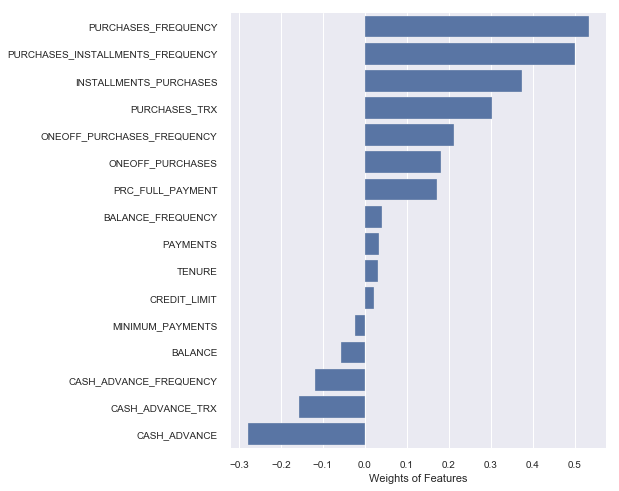

In [125]:
pca_barchart(pca_sort_weights(1))

The first principal component explains 45.5\% of the variance. This principal component seems to represent customers with high purchase frequency, especially installment purchases and low cash advance frequency. 

## Second Group of Customers

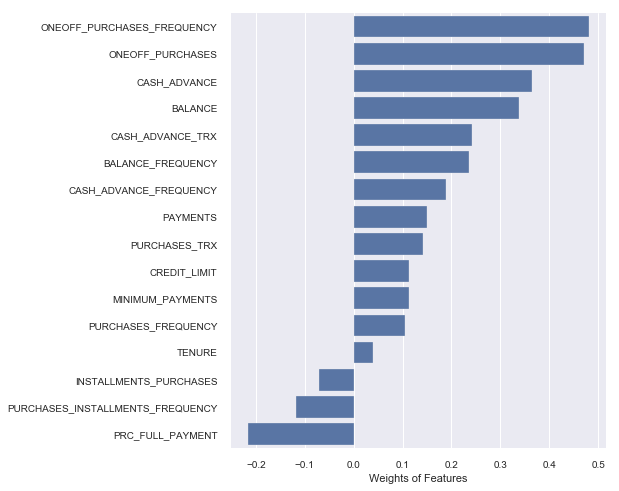

In [126]:
pca_barchart(pca_sort_weights(2))

This group of customers seems to frequently have oneoff purchases and cash advance but rarely make installment purchases.

## Third Group of Customers

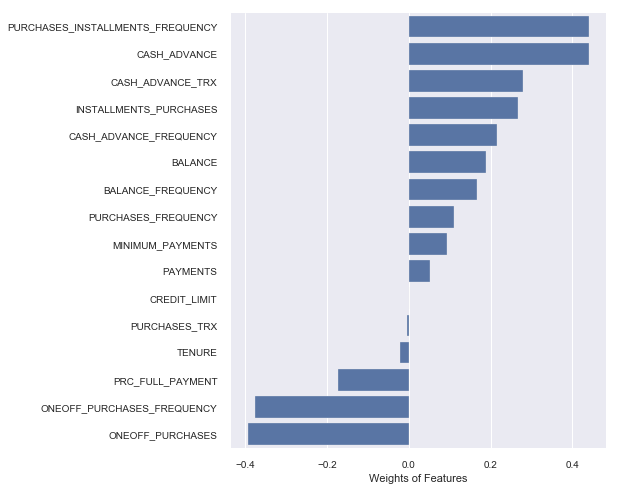

In [127]:
pca_barchart(pca_sort_weights(3))

This group seems to make installment purchases and withdraws cash advances frequently but rarely makes one-off purchases.

## Fourth Group of Customers

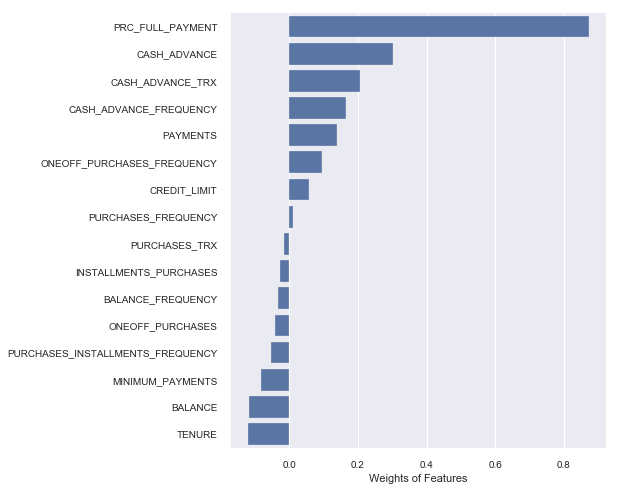

In [128]:
pca_barchart(pca_sort_weights(4))

This group seems to pay their bills in full and use the credit card mostly for cash advances. The tenure of the credit card seems to be short and the balance is low.

## Fifth Group of Customers

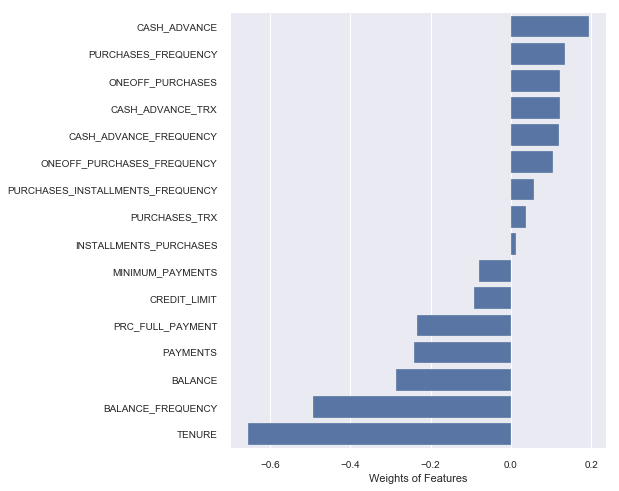

In [129]:
pca_barchart(pca_sort_weights(5))

This group seems to use the credit card sometimes for a cash advance or oneoff purchases but have short-tenure credit cards and will rarely use the credit card (low-balance, low-payment).

## Business Insights

1. This group seems to represent customers with high purchase frequency, especially installment purchases and low cash advance frequency. Therefore, we could we could create a card which offers discounts in some popular subscription products. 

2. This group of customers seems to frequently have oneoff purchases and cash advance but rarely make installment purchases. We could we could create a card which offers some discount offers for one-off purchase products and provides a lower financing fee for cash advances.

3. This group seems to make installment purchases and withdraws cash advances frequently but rarely makes one-off purchases. We could create a card which offers discounts in some popular subscription products and lower financing fee for cash advances.

4. This group seems to pay their bills in full and use the credit card mostly for cash advances.  For this group of people, we could create a card which offers lower financing fees for cash advances and a low APR, higher minimum payment credit card, which would be attractive for them as they already pay in full.

5. This group seems to use the credit card sometimes for a cash advance or oneoff purchases but have short-tenure credit cards and will rarely use the credit card (low-balance, low-payment). We don't need to create a new credit card for them as they seem to bring low revenue for the company and a credit card similar to the one for group 2 would be attractive for them.

In summary, this analysis provides suggestions about creating four credit cards with the benefits and offers described above, which would be attractive to four main types of customers.